In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sgeo
import osmnx
import pyrosm
import os
%matplotlib inline

# Network routing

In the previous exercise, we have generated a trip table with origin and destination coordinates. In this exercise, we will make use of OpenStreetMap data to route the individual trips on the networks and show which roads are used by the generated trips.

The following steps will be followed:
- We download OpenStreetMap data for Île-de-France
- We use a tool called `osmium` to out only the city of Paris (to speed up routing) and to bring the raw data in the right format
- We make use of the library `osmnx` to prepare the network data for routing
- We make use of the library to route all generated trips from the previous exercise on the network
- We plot the flow along the road network that is created by the trips

First, we load in the trip information and the municipality data:

In [3]:
df_trips = gpd.read_parquet("data/trips.parquet")
df_municipalities = gpd.read_parquet("data/municipalities.parquet")

**Task**: Filter the municipalities such that only Paris remains in the data set.

In [9]:
### Insert code here
# df_perimeter = 

### SOLUTION START
df_perimeter = df_municipalities[df_municipalities["municipality_id"].str[:2] == "75"].dissolve()
df_perimeter.to_crs("EPSG:4326").to_file("data/perimeter.geojson")

Now, we merge all municipalities into one polygon and save the dataframe in GeoJson format. We'll need it later for cutting the OpenSteetMap data.

In [10]:
# Merge multiply polygons into one
df_perimeter = df_perimeter.dissolve()

# Write as GeoJson format file. You can have a look at it in QGIS, for instance.
df_perimeter.to_crs("EPSG:4326").to_file("data/perimeter.geojson")

## Preparing OpenStreetMap data

In this part, we will download the OpenStreetMap data, and use `osmium` (installed as a command-line utility in your `conda` environment) to cut and convert it for further processing. Please follow the following steps.

### OpenStreetMap data

The whole OpenStreetMap data set is large, so there are providers of smaller cut-outs. One useful source of such cut-outs is GeoFabrik, which provides per-region data sets for France: http://download.geofabrik.de/europe/france.html

- Download the latest data for Île-de-France in `.osm.pbf` format and put the file next to this notebook.

Linux users may execute the following cell:

In [11]:
if not os.path.exists("data/ile-de-france-latest.osm.pbf"):
    !cd data && wget http://download.geofabrik.de/europe/france/ile-de-france-latest.osm.pbf

Next, we (1) cut the OpenStreetMap data to the selected perimeter (Paris) and, (2) only retain road geometries in the file:

In [14]:
!osmium extract data/ile-de-france-latest.osm.pbf -p data/perimeter.geojson --overwrite -o data/cut.osm.pbf
!osmium tags-filter --overwrite -o data/perimeter.osm.pbf data/cut.osm.pbf w/highway

[======================================================================] 100% 
[======================================================================] 100% 


## Loading the OpenStreetMap data

We are now ready to read the data and make use of it in this notebook. For that, we make use of the `pyrosm` library. Further processing of the data happens using `osmnx` and `networkx`.

In [15]:
# Load our cut perimetecr data
osm = pyrosm.OSM("data/perimeter.osm.pbf")

# Extract nodes and edges from the road network
nodes, edges = osm.get_network(nodes = True, network_type = "driving")

# Convert the data into a graph that can be used with the networkx library
graph = osm.to_graph(nodes, edges, graph_type = "networkx")

Next, we add link speeds and travel times to the network based on OSM information:

In [16]:
osmnx.add_edge_speeds(graph)
osmnx.add_edge_travel_times(graph)

**Task**: Write out the network in GeoPackage format and have a look at it in QGIS. Hint: Only output the `geometry` column to avoid long writing times for all the attributes in the dataframe.

In [17]:
df_network = osmnx.graph_to_gdfs(graph, nodes = False, edges = True)

# Insert your code here

### SOLUTION START
df_network[["geometry"]].reset_index().to_file("data/network.gpkg")

### Routing

In order to route the trips in our *trips* dataframe through the road network, we need to assign each origin and destination (by coordinate) to a specififc network node:

In [31]:
# add origin_node column to our data frame
geometry = df_trips["origin_geometry"].to_crs("EPSG:4326")
df_trips["origin_node"] = osmnx.nearest_nodes(graph, geometry.x, geometry.y)

# add destination_node column to our data frame
geometry = df_trips["destination_geometry"].to_crs("EPSG:4326")
df_trips["destination_node"] = osmnx.nearest_nodes(graph, geometry.x, geometry.y)

**Task**: Look at the updated dataframe and note down one combination of origin and destination node. Use `osmnx.shortest_path` to perform a routing through the network:

In [33]:
# Insert your code here

# origin_node = 
# destination_node = 

# route = osmnx.shortest_path(graph, ..., weight = "travel_time")

### SOLUTION START

origin_node = df_trips["origin_node"].values[0]
destination_node = df_trips["destination_node"].values[0]
route = osmnx.shortest_path(graph, origin_node, destination_node, weight = "travel_time")

Print the obtained route. What does it represent?

In [34]:
route

[11056219133,
 5528037247,
 151363076,
 5528037246,
 5528037254,
 34632784,
 11056219140,
 5717695500,
 11056219139,
 8780866191,
 5528037430,
 34632783,
 5528037426,
 6318436010,
 34632819,
 256423560,
 5528037428,
 5286587720,
 5528037433,
 431394917,
 17809169,
 152739326,
 2490369942,
 8900878788,
 6335361963,
 5528037505,
 178888599,
 8809450,
 458367263,
 5528037504,
 6365085736,
 5528037503,
 431394176,
 8809447,
 2284436606,
 327517717,
 11295465659,
 2284436597,
 8809442,
 2284436596,
 8809443]

**Task**: Use `osmnx.route_to_gdf` to generate a dataframe that contains the route as a geometry. Visualize the resulting data in QGIS.

In [35]:
df_route = osmnx.route_to_gdf(graph, route)

# Insert your code here

### SOLUTION START
df_route.to_file("data/route.gpkg")

AttributeError: module 'osmnx' has no attribute 'route_to_gdf'

**Task**: Now, calculate, at least 200 routes or more from your trips data frame. You can pass a list of origin nodes and a list of destination nodes to `osmnx.shortest_path`.

In [36]:
### Insert your code here

#routes = ...

### SOLUTION START
N = 200

routes = osmnx.shortest_path(
    graph, df_trips["origin_node"].iloc[:N], df_trips["destination_node"].iloc[:N], weight = "travel_time"
)

We have now obtained a list of routes, one for each trip. A route is simply a list of nodes. By always noting down one node in a route, and its successor, we can obtain a data frame that counts the number of traversals of each edge:

In [28]:
df_count = { "u": [], "v": [] }

for route in routes:
    for k in range(1, len(route)):
        df_count["u"].append(route[k - 1])
        df_count["v"].append(route[k])

df_count = pd.DataFrame(df_count)
df_count = df_count.groupby(["u", "v"]).size().reset_index(name = "count")

df_count.sort_values(by = "count", ascending = False).head()

,u,v,count
2736,147875806,368250,20
15450,11187908908,147024331,20
9296,3980096126,147875806,20
2728,147024331,3980096126,20
165,368252,11264503561,18


Now we can create a geographic data frame that contains the network, and we merge the counts on top:

In [29]:
df_count = pd.merge(df_network, df_count, on = ["u", "v"])

**Task**: Plot the network using the `count` column in this notebook or in QGIS.

<Axes: >

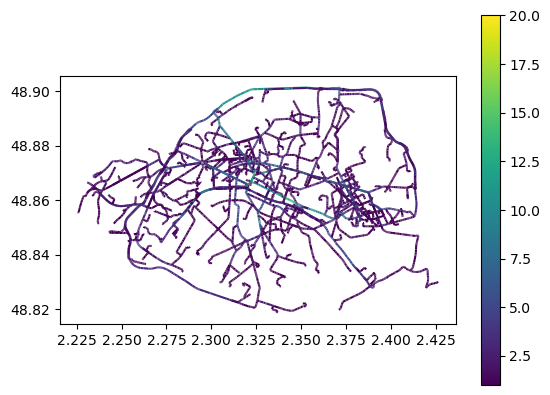

In [30]:
### Insert code here
# ...

df_count.plot("count", legend = True)

**Congratulations!** You should now be able to cut a road network for the course project (Exercise 3.2).